## Testing several pre-trained CNN's to determine which one to use for the project

In [1]:
# for loading/processing the images and the models  
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications import vgg16, resnet50, inception_v3, mobilenet, xception  
from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle
import time
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

This code uses a dataset of 210 flower images to test the CNN's. Dataset is retreived from: https://www.kaggle.com/datasets/olgabelitskaya/flower-color-images

In [2]:
# Change path
path = r"C:\Users\heisu\OneDrive\ドキュメント\STREETS\data\Delft_NL\imagedb" 

os.chdir(path)

# this list holds all the image filename
flowers = []

# creates a ScandirIterator aliased as files
with os.scandir(path) as files:
  # loops through each file in the directory
    for file in files:
        if file.name.endswith('.png'):
          # adds only the image files to the flowers list
            flowers.append(file.name)

# exclude images with _s_a and _s_b
images = [x for x in flowers if not x.endswith('_s_a.png')]
images = [x for x in images if not x.endswith('_s_b.png')]


# only the first 100 images
images = images[:100]

Select which models you want to compare

In [3]:
# modules = [vgg16, resnet50, inception_v3, mobilenet, xception]
# models = [vgg16.VGG16(), resnet50.ResNet50(), 
#           inception_v3.InceptionV3(), mobilenet.MobileNet(), 
#           xception.Xception()]

# List of models that will be used
modules = [vgg16, resnet50, mobilenet]
models = [vgg16.VGG16(), resnet50.ResNet50(), mobilenet.MobileNet()]

Function to extract the features from an image using a pretrained CNN

In [4]:
def extract_features(file, model, module):
    # load the image as a 224x224 array
    img = load_img(file, target_size=(224,224))
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img) 
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3) 
    # prepare image for model
    imgx = module.preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True, verbose=0)
    return features


Function for extracting the features and timing it. After that, a simple k-means cluster will be used to cluster the data. The inertia of the clusters will be calculated, which can be used to compare the CNN's.

In [5]:
def test_model(file, model, module, n_cluster):
    """Input model and returns time it takes to create the feature extraction vectors and
    a measure of accuracy when using kmeans on the feature extraction vectors"""

    model = Model(inputs = model.inputs, outputs = model.layers[-2].output)
    
    data = {}
    
    start_time = time.time()

    # loop through each image in the dataset
    for image in images:
        # try to extract the features and update the dictionary
        try:
            feat = extract_features(image,model,module)
            data[image] = feat
        # if something fails, save the extracted features as a pickle file (optional)
        except:
            print('Fail')
            pass
            
    end_time = time.time()
    time_taken = end_time - start_time

    # get a list of just the features
    feat = np.array(list(data.values()))

    # reshape so that there are 210 samples of x no. of vectors
    feat = feat.reshape(len(images),-1)


    # get the unique labels (from the flower_labels.csv)
    # df = pd.read_csv('flower_labels.csv')
    # label = df['label'].tolist()
    # unique_labels = list(set(label))


    # reduce the amount of dimensions in the feature vector
    pca = PCA(n_components=100, random_state=22)
    
    try:
        pca.fit(feat)
    except:
        return np.nan, np.nan
    x = pca.transform(feat)

    kmeans = KMeans(n_clusters=n_cluster, random_state=22)
    kmeans.fit(x)
   
    sse = kmeans.inertia_

    return time_taken, sse

Run the for-loop over the different models for a certain number of iterations.
The time taken to extract the features and the inertia will be saved in a 2d array

In [19]:
iter = 5 # number of iterations
N_cluster = [i for i in range(1, 11)]    # from 1 to 10 clusters
time_taken_arr = np.zeros((len(models), len(N_cluster), iter))
sse_arr = np.zeros((len(models), len(N_cluster), iter))

for m in range(len(models)):
    print(f'\nStart with new model: {m}')
    for cluster in N_cluster:
        print(f'Number of clusters: {cluster}')
        for i in range(iter):
            print(f'Iteration {i}')
            time_taken, sse = test_model(file, models[m], modules[m], cluster)
            time_taken_arr[m, cluster-1, i] = time_taken
            sse_arr[m, cluster-1, i] = sse


Start with new model: 0
Number of clusters: 1
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Number of clusters: 2
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Number of clusters: 3
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Number of clusters: 4
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Number of clusters: 5
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Number of clusters: 6
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Number of clusters: 7
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Number of clusters: 8
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Number of clusters: 9
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Number of clusters: 10
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4

Start with new model: 1
Number of clusters: 1
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Number of clusters: 2
Iteration 0
Iteration 1
I

In [20]:
time_taken_arr

array([[[18.75327277, 20.08753681, 19.40399051, 18.86248708,
         18.9825964 ],
        [19.0041275 , 19.35296416, 19.428514  , 19.42093086,
         19.58340573],
        [19.65715003, 19.70846367, 19.54271007, 19.67169809,
         19.47302866],
        [19.56399941, 19.7763288 , 19.55078506, 19.55447912,
         19.60576773],
        [19.6356771 , 19.35694957, 19.42096972, 19.42101264,
         19.36011219],
        [19.52112246, 19.61765456, 19.37685204, 19.340096  ,
         19.50065398],
        [19.39109969, 19.33766794, 19.6394937 , 19.29614902,
         19.38092589],
        [19.63297939, 19.40547729, 19.3124249 , 19.40237284,
         19.23377013],
        [19.39587927, 19.54291987, 19.40083146, 19.40077806,
         19.50469708],
        [19.64605165, 19.32197237, 19.45558286, 19.39239144,
         19.43602586]],

       [[13.64270163, 14.26895094, 14.75800729, 14.83721781,
         14.38705111],
        [14.56331253, 14.36974621, 14.29453659, 14.78078794,
         14.4

In [21]:
sse_arr

array([[[182178.375     , 182178.375     , 182178.375     ,
         182178.375     , 182178.375     ],
        [142939.203125  , 142939.203125  , 142939.203125  ,
         142939.203125  , 142939.203125  ],
        [132024.5625    , 132024.5625    , 132024.5625    ,
         132024.5625    , 132024.5625    ],
        [121612.3515625 , 121612.3515625 , 121612.3515625 ,
         121612.3515625 , 121612.3515625 ],
        [116198.09375   , 116198.09375   , 116198.09375   ,
         116198.09375   , 116198.09375   ],
        [113572.2109375 , 113572.2109375 , 113572.2109375 ,
         113572.2109375 , 113572.2109375 ],
        [109204.1015625 , 109204.1015625 , 109204.1015625 ,
         109204.1015625 , 109204.1015625 ],
        [107094.1796875 , 107094.1796875 , 107094.1796875 ,
         107094.1796875 , 107094.1796875 ],
        [103692.6875    , 103692.6875    , 103692.6875    ,
         103692.6875    , 103692.6875    ],
        [ 99197.6796875 ,  99197.6796875 ,  99197.6796875 ,
    

([<matplotlib.axis.XTick at 0x1ced19a9d00>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

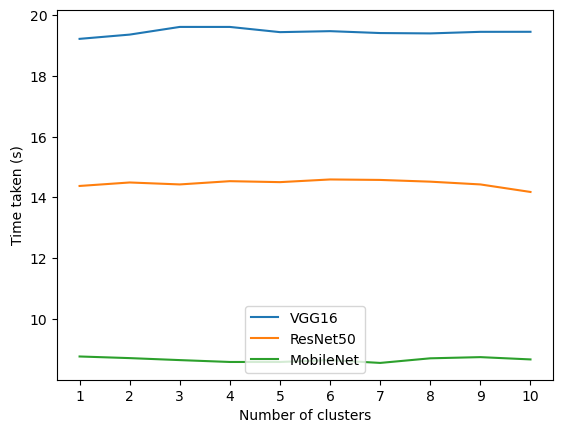

In [22]:
# time taken per number of clusters
plt.plot(N_cluster, np.mean(time_taken_arr[0], axis=1), label='VGG16')
plt.plot(N_cluster, np.mean(time_taken_arr[1], axis=1), label='ResNet50')
plt.plot(N_cluster, np.mean(time_taken_arr[2], axis=1), label='MobileNet')
plt.xlabel('Number of clusters')
plt.ylabel('Time taken (s)')
plt.legend()
plt.xticks(N_cluster)

([<matplotlib.axis.XTick at 0x1cec00d6220>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

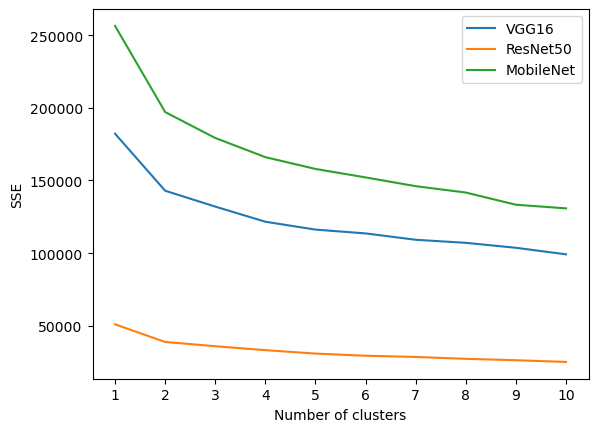

In [23]:
# sse per number of clusters
plt.plot(N_cluster, np.mean(sse_arr[0], axis=1), label='VGG16')
plt.plot(N_cluster, np.mean(sse_arr[1], axis=1), label='ResNet50')
plt.plot(N_cluster, np.mean(sse_arr[2], axis=1), label='MobileNet')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.legend()
plt.xticks(N_cluster)

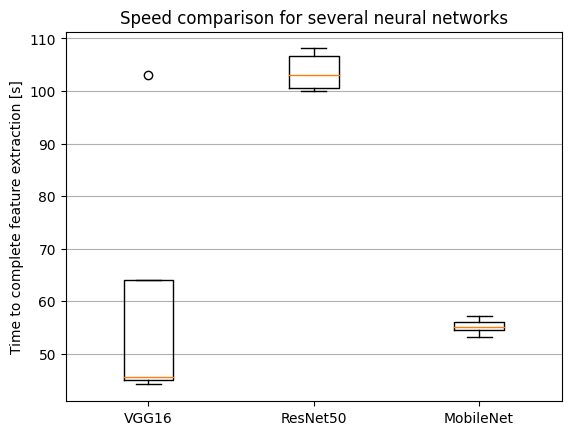

In [66]:
plt.boxplot(time_taken_arr.T)
plt.xticks([1, 2, 3], labels=['VGG16', 'ResNet50', 'MobileNet'])
plt.ylabel('Time to complete feature extraction [s]')
plt.title('Speed comparison for several neural networks')
plt.grid(axis='y')

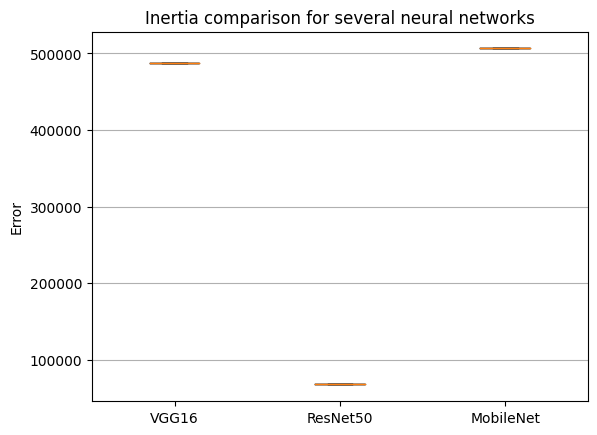

In [67]:
plt.boxplot(sse_arr.T)
plt.xticks([1, 2, 3], labels=['VGG16', 'ResNet50', 'MobileNet'])
plt.ylabel('Error')
plt.title('Inertia comparison for several neural networks')
plt.grid(axis='y')